In [1]:
import numpy as np
import sys; sys.path.append('../rrr')
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *
plt.rcParams['text.usetex'] = True

# 2D Intuition for Input Gradients

The goal of this notebook is to show how input gradients relate to a model's decision boundary. In particular, we'll create two simple 2D datasets with different numbers of classes (and pretty arbitrary actual boundaries), then compute and plot input gradients as vector fields.

## 2-class dataset

Let's do the simple, binary classification case:

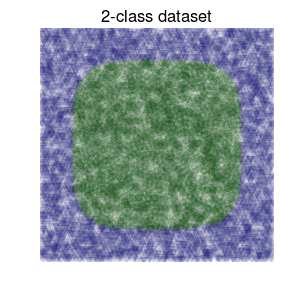

In [2]:
true_fn = lambda x,y: x**4 + y**4

X = np.random.random((20000,2))*100-50
mean = np.mean([true_fn(x,y) for x,y in X])*0.66
y = np.array([true_fn(x,y) > mean for x,y in X]).astype(int)
pos = X[np.argwhere(y==1).T[0]]
neg = X[np.argwhere(y==0).T[0]]

plt.figure(figsize=(3,3))
plt.title("2-class dataset")
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.scatter(pos[:,0], pos[:,1], c='blue', marker='v', alpha=0.05)
plt.scatter(neg[:,0], neg[:,1], c='green', alpha=0.05)
plt.axis('off')
plt.show()

In [3]:
mlp = MultilayerPerceptron()
mlp.fit(X,y)
mlp.score(X,y)

0.98709999999999998

Because we're using a powerful model like an MLP, we can classify this dataset very well despite the nonlinear decision boundary.

We can take gradients with respect to the probabilities or log probabilities of predicting 0, 1, the maximum (e.g. the predicted class), or the sum:

In [4]:
l_grads0 = mlp.input_gradients(X, scale='log', y=0)
l_grads1 = mlp.input_gradients(X, scale='log', y=1)
l_gradsm = mlp.input_gradients(X, scale='log', y='max')
l_gradss = mlp.input_gradients(X, scale='log', y='sum')

p_grads0 = mlp.input_gradients(X, scale='lin', y=0)
p_grads1 = mlp.input_gradients(X, scale='lin', y=1)
p_gradsm = mlp.input_gradients(X, scale='lin', y='max')
p_gradss = mlp.input_gradients(X, scale='lin', y='sum')

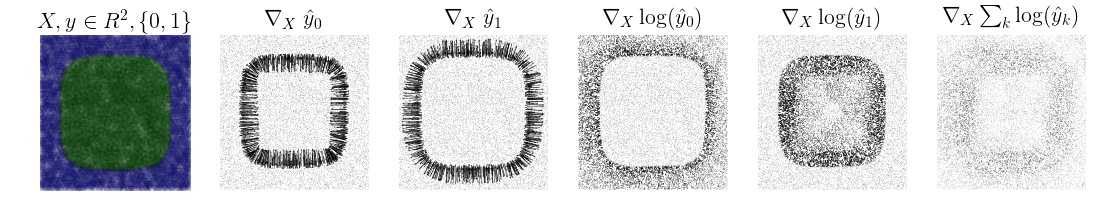

In [63]:
plt.figure(figsize=(13.5,2))
fs = 16

def plot_grads(X, grads):
  plt.axis('off')
  plt.xlim(X[:,0].min(), X[:,0].max())
  plt.ylim(X[:,1].min(), X[:,1].max())
  plt.quiver(X[:,0], X[:,1], grads[:,0], grads[:,1])
  
plt.subplot(161)
plt.title(r'$X,y\in\mathbb{R}^2,\{0,1\}$', fontsize=fs)
plt.scatter(pos[:,0], pos[:,1], c='blue', marker='v', alpha=0.05)
plt.scatter(neg[:,0], neg[:,1], c='green', alpha=0.05)
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.axis('off')

plt.subplot(164)
plt.title(r'$\nabla_X \log(\hat{y}_0)$', fontsize=fs)
plot_grads(X, l_grads0)

plt.subplot(165)
plt.title(r'$\nabla_X \log(\hat{y}_1)$', fontsize=fs)
plot_grads(X, l_grads1)

plt.subplot(162)
plt.title(r'$\nabla_X\ \hat{y}_0$', fontsize=fs)
plot_grads(X, p_grads0)

plt.subplot(163)
plt.title(r'$\nabla_X\ \hat{y}_1$', fontsize=fs)
plot_grads(X, p_grads1)

plt.subplot(166)
plt.title(r'$\nabla_X \sum_k \log(\hat{y}_k)$', fontsize=fs)
plot_grads(X, l_gradss)

plt.show()

This hopefully provides some intuition about what input gradients are / mean; they help define the decision boundary and lie normal to it. The gradients of the raw probabilities are significant only near the decision boundary, while the log probabilities increase more gradually (then drop off after). Their sum, while fainter, encapsulates both sides.

It's also interesting to look at the maximum (i.e. the gradients of the probability of the predicted class):

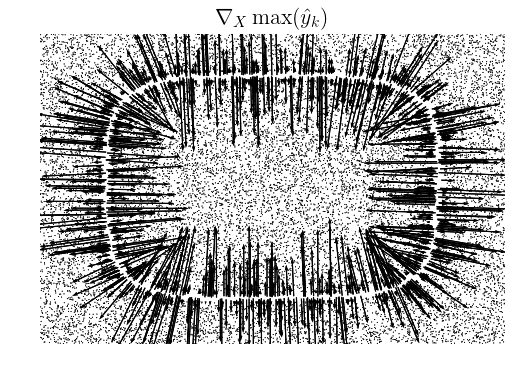

In [69]:
plt.title(r'$\nabla_X \max(\hat{y}_k)$', fontsize=fs)
plot_grads(X, l_gradsm)
plt.show()

We see that near the boundary, we can maximize the probability of the predicted class by moving _away_ from the boundary, which makes sense.

Let's look at an example with more classes:

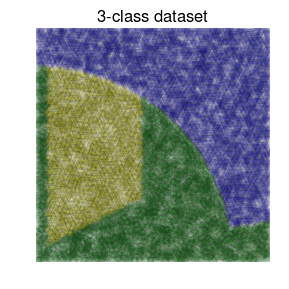

In [21]:
X2 = np.random.random((30000,2))*100

def y_fn(x,y):
  if x**2 + y**2 > 7000 and 3*x - 17*y < 14:
    return 0
  elif x**2.5 + 12*np.sin(y) < 50 or x > 45 or y < 5 + 0.5*x:
    return 1
  else:
    return 2

y2 = np.array([y_fn(x,y) for x,y in X2])
kls1 = X2[np.argwhere(y2==0).T[0]]
kls2 = X2[np.argwhere(y2==1).T[0]]
kls3 = X2[np.argwhere(y2==2).T[0]]

plt.figure(figsize=(3,3))
plt.title("3-class dataset")
plt.xlim(0,100)
plt.ylim(0,100)
plt.scatter(kls1[:,0], kls1[:,1], c='blue', marker='v', alpha=0.05)
plt.scatter(kls2[:,0], kls2[:,1], c='green', alpha=0.05)
plt.scatter(kls3[:,0], kls3[:,1], c='yellow', marker='^', alpha=0.05)
plt.axis('off')
plt.show()

In [22]:
mlp2 = MultilayerPerceptron()
mlp2.fit(X2,y2)
mlp2.score(X2,y2)

0.98399999999999999

In [24]:
l_grads2_1 = mlp2.input_gradients(X2, scale='log', y=0)
l_grads2_2 = mlp2.input_gradients(X2, scale='log', y=1)
l_grads2_3 = mlp2.input_gradients(X2, scale='log', y=2)
l_grads2_m = mlp2.input_gradients(X2, scale='log', y='max')
l_grads2_s = mlp2.input_gradients(X2, scale='log', y='sum')

p_grads2_1 = mlp2.input_gradients(X2, scale='lin', y=0)
p_grads2_2 = mlp2.input_gradients(X2, scale='lin', y=1)
p_grads2_3 = mlp2.input_gradients(X2, scale='lin', y=2)
p_grads2_m = mlp2.input_gradients(X2, scale='lin', y='max')
p_grads2_s = mlp2.input_gradients(X2, scale='lin', y='sum')

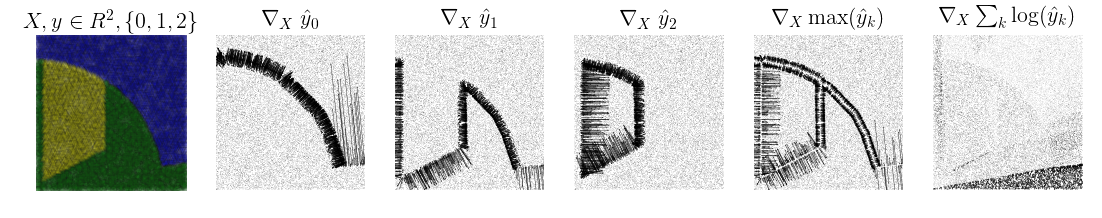

In [64]:
plt.figure(figsize=(13.5,2))
fs = 16

plt.subplot(161)
plt.title(r'$X,y \in \mathbb{R}^2,\{0,1,2\}$', fontsize=fs)
plt.xlim(0,100)
plt.ylim(0,100)
plt.scatter(kls1[:,0], kls1[:,1], c='blue', marker='v', alpha=0.05)
plt.scatter(kls2[:,0], kls2[:,1], c='green', alpha=0.05)
plt.scatter(kls3[:,0], kls3[:,1], c='yellow', marker='^', alpha=0.05)
plt.axis('off')

plt.subplot(162)
plt.title(r'$\nabla_X\ \hat{y}_0$', fontsize=fs)
plot_grads(X2, p_grads2_1)

plt.subplot(163)
plt.title(r'$\nabla_X\ \hat{y}_1$', fontsize=fs)
plot_grads(X2, p_grads2_2)

plt.subplot(164)
plt.title(r'$\nabla_X\ \hat{y}_2$', fontsize=fs)
plot_grads(X2, p_grads2_3)

plt.subplot(165)
plt.title(r'$\nabla_X \max(\hat{y}_k)$', fontsize=fs)
plot_grads(X2, p_grads2_m)

plt.subplot(166)
plt.title(r'$\nabla_X \sum_k \log(\hat{y}_k)$', fontsize=fs)
plot_grads(X2, l_grads2_s)

plt.show()

Even with multiple classes, input gradients still define the decision boundary between all of them pretty well. The sum is a little more complicated but still captures much of the essential behavior further away from the boundaries, while the max provides the best overall visualization.

It's also interesting to consider the different magnitudes:

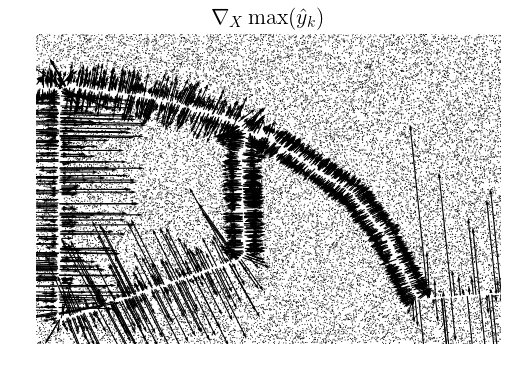

In [67]:
plt.title(r'$\nabla_X \max(\hat{y}_k)$', fontsize=fs)
plot_grads(X2, l_grads2_m)
plt.show()

The relative magnitudes are larger in some of the bottom boundaries than the top ones. What does this imply about the model's behavior near those regions?